import all relevant modules

In [52]:
from Bio import SeqIO, AlignIO, Phylo
from Bio.SeqRecord import SeqRecord
import Bio.Align
from Bio.Align.AlignInfo import SummaryInfo
from Bio.Seq import Seq
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor

import matplotlib
import matplotlib.pyplot as plt
from pymsaviz import MsaViz

import os
import time
import random 
import pandas as pd
import numpy as np 


Setup the directory

In [83]:
#set up directories
dog_breeds = r"/workspaces/Coursework/my_project/data/dog_breeds.fa"
mystery_breed = r"/workspaces/Coursework/my_project/data/mystery.fa"
output = r"/workspaces/Coursework/my_project/results"
ind_breeds = r"/workspaces/Coursework/my_project/results/individual_breed_sequences"
all_alignments = r"/workspaces/Coursework/my_project/results/All_alignments"
consensus_file = r"/workspaces/Coursework/my_project/results/concensus_sequences"
MSA_alignment = r"/workspaces/Coursework/my_project/results/MSA_alignment"

Set up basic functions 

In [54]:
def read_fasta(filename):
    """function which reads a fasta file and returns a list of sequences found in the file"""
    sequences = []
    #read the file
    for record in SeqIO.parse(filename, "fasta"):
        #add each sequence to the list
        sequences.append(record.seq)
    return(sequences)

def create_output(content, filename:str, filetype:str):
        """creates a file in the results folder with the content provided in the the correct format (either txt or fasta)"""
        #create an empty file by openening it in a write format 
        filepath = f"{output}/{filename}"
        with open(filename, "w") as f:
                #if the filetype is fasta crete a file using SeQIO
                if filetype == "fasta":
                        SeqIO.write(content, filepath, filetype)
                #otherwise if the file is a txt write the content to the file 
                elif filetype == "txt":
                        f.write(content)
                #if neither is true return an error message         
                else:
                    return "Provide a valid file type, this function only creates fasta files and txt files."
                    
def simple_alignment(seq1,seq2):
    """align two sequences given as parameters and return alignment score and alignment"""
    #set up aligner
    aligner = Bio.Align.PairwiseAligner()
    #get alignemnt score 
    score = aligner.score(seq1, seq2)
    #get alignemnt
    alignment = aligner.align(seq1, seq2)
    return score, alignment



Set up the Breed class 

In [70]:
class Breed():
    """This class stores information about every breed and their sequence"""
    #create a list to store all instances of the class
    all_instances = []
    #define an init function which stores the sequence as a sequence object, the breed as a string and the fasta format of the sequence
    def __init__(self, sequence, breed, fasta):
        self.sequence = sequence
        self.breed = breed
        self.fasta = fasta
        #store all initialised instances in the defined list
        Breed.all_instances.append(self) 

#initialise the Breed class
def initialise_Breed(filename = dog_breeds, format = "fasta"):
    #parse through the dog_breeds file
    for record in SeqIO.parse(filename, format):
        #get the description of each sequence to find out what breed it is 
        #split the description on "[" as these are used to separate each descriptor
        for key in list(record.description.split("[")): 
            #if the keyword breed is in the description but the keyword "isolate" is not in thr description it will define the dog breed 
            if "breed" in key and "isolate" not in key:
                #each sequence in filename gets assigned a name based on the breed identified in the desciption
                breed_name = (key[6:-2]).upper()
                #intialises an object of class Breed which contains the sequence, breed name and the full record 
                record.name = Breed(record.seq, breed_name, record)
#call the function
initialise_Breed()

Create consensus files for each breed

In [56]:
def unique_breeds():
    """Set up a list that contains all unique breed names from the class Breed in a list"""
    all_breeds = set()
    #itterate through all instances in Breed class
    for key in Breed.all_instances:
        #access and add every breed to the all_breeds set
        all_breeds.add(key.breed)
    return all_breeds
    
def breed_sequences(directory = ind_breeds):
    """Write a fasta file containing all sequences that belong to the same breed """
    for breed in unique_breeds():
        #creates a temporary variable corresponding to each individual dog breed 
        temp = breed
        #create a directory for filename
        filename = f"{directory}/{breed}.fa"
        #itterate throough all instances of the class Breed
        sequences = []
        for key in Breed.all_instances: 
            #check if the breedd is the same as the current breed in the loop stored in the temp variable 
            if key.breed == temp:
                sequences.append(key.fasta)
        #adds the sequences to a file with the name of the breed as a filename
        SeqIO.write(sequences, filename, "fasta") 

breed_sequences()
def consensus_seq(filename):
    """Function that takes in a file containing a number of sequences and returns a consensus sequence"""
    os.chdir(ind_breeds) 
    #align all the sequences in each file
    alignments = AlignIO.parse(filename, "fasta") 
    for alignment in alignments: 
        #get summary info of each alignment to create a consensus 
        summary = SummaryInfo(alignment) 
        #create a consensus of each alignment 
        consensus = summary.dumb_consensus() 
        #create a fasta format sequence using the consensus sequence and recordname
        seq_record = SeqRecord(Seq(consensus), id=filename) 
        #add each consensus seq to a list 
    return seq_record


def consensus_file(directory=output):
    """create a consensus sequence for each breed and store it in a list"""
    #create a list to store the sequences
    consensus_sequences = [] 
    for file in unique_breeds():
        #run the consensus_seq function to get the consensus file of each breed in the consensus list 
        consensus_sequences.append(consensus_seq(file))
    return consensus_sequences
        
def add_mystery_to_consensus():
    consensus_sequences = list(consensus_file())
    unknown_sequence = (read_fasta(mystery_breed))[0]
    #add mystery sequence to the consensus file list 
    consensus_sequences.append(SeqRecord(unknown_sequence, id="MYSTERY SEQUENCE"))
    return consensus_sequences

#store consensus sequences in a results folder in a file called consensus_sequences
create_output(consensus_file(), "consensus_sequences", "fasta" )
#create output with the mystery sequence
create_output(add_mystery_to_consensus(), "consensus_sequences_with_mystery", "fasta" )
#hold the list as a value for easy acess later on 
consensus_sequences_with_unknown = add_mystery_to_consensus()

Create a class to store consensus sequences 

In [69]:
#get consensus sequences
consensus_file = f"{output}/consensus_sequences"
consensus_sequences = read_fasta(consensus_file)
#get mystery sequences
mystery_sequence = read_fasta(mystery_breed)

class Breed_consensus():
    """This class stores information about every breed and their sequence"""
    #create a list to store all instances of the class
    all_instances = []
    #define an init function which stores the sequence as a sequence object, the breed as a string and the fasta format of the sequence
    def __init__(self, sequence, breed, fasta):
        self.sequence = sequence
        self.breed = breed
        self.fasta = fasta
        #store all initialised instances in the defined list
        Breed_consensus.all_instances.append(self) 
#open the fasta file and save the sequence breed and sequence name in a Breed Class to be accessed later
def initialise_Breed_consensus(filename = consensus_file, format = "fasta"):
    #parse through the dog_breeds file
    for record in SeqIO.parse(filename, format):
            #intialises an object of class Breed which contains the sequence, breed name and the full record 
            breed_name = record.description.replace("<unknown description>", "")
            record.id = Breed_consensus(record.seq, breed_name, record)
#call the function
initialise_Breed_consensus()


Find the top alignment and store it in a file (this function is the one which takes the longest)

In [58]:
#align_consensus sequences with the mystery sequence
def align_consensus(sequences_list=consensus_sequences, unknown_sequence = mystery_sequence[0]):
    """uses the simple alignment function to cretae an alignment between unknown sequence and database. Returns the score and alignment of the top scoring alignment."""
    #set up a list for all alignment score 
    current_best = 0
    current_best_alignment = 0
    current_sequence = 0
    top_breed = ""
    #itterate through the sequences in the database
    for sequence in sequences_list:
        #determine the score of each alignment
        score = (simple_alignment(sequence, unknown_sequence)[0])
        if score > current_best:
            current_best = score
            alignment = (simple_alignment(sequence, unknown_sequence)[1])
            current_sequence = sequence
            current_best_alignment = alignment
    for key in Breed_consensus.all_instances:
        if key.sequence == current_sequence:
            top_breed = key.breed
    print(current_best, current_best_alignment, top_breed)
    return current_best, current_best_alignment, top_breed


top_alignment_details = align_consensus()
top_alignment = top_alignment_details[1][0]

#create a directory for the top alignment file 
filename = f"{output}/top_alignment_output"  
#create a file to store the top scoring alignment as clustal file 
with open(filename, "w"):
        Bio.Align.write(top_alignment, filename, "clustal")

16705.0 <Bio.Align.PairwiseAlignments object at 0x7fc9803ca200> 


Calculate percentage similarity of the top scoring sequence 

In [59]:
def percentage_similarity(aln):
    """Given a pairwise alignment calculates the percentage similarity between the two sequences"""
    #create a varieble to store the instances where columns are identical
    identical_columns = float()
    #itterate through every column of the alignment
    for a in range(len(aln[0])): 
        #check if first and second sequence is the same at point a, a describing the column 
        if aln[0,a] == aln[1,a]: 
            #if base at position a is the same in both sequences add 1 to the amount of identical columns 
            identical_columns += 1
    #calculate the percentage based on the identical columns number and the length of the alignment 
    percentage = 100 * identical_columns / float(len(aln[0])) 
    #return percentage to 3dp
    return  round(percentage,3) 

#calculate percentage similarity of the top scoring sequence 
top_percentage = percentage_similarity(top_alignment)

Save the results to a text file containing an explanation of the values generated 
-create a pymasviz grpah to better visualise the alignment, stored in results 

In [60]:
#get results aka the breed, its sequence and percentage similarity 
results = "The breed most similar to the mystery DNA file is the", top_alignment_details[2], "its percent identity is", top_percentage, "%" ,"the alignment of the mystery dog breed and", top_alignment_details[2], "is displayed here\n", top_alignment

#create a string representing thr results that can be written to the results file 
results_str = str()
for key in results:
    results_str += str(key) 

#create a directory and filename for the details of the top alignment
filename2 = f"{output}/top_alignment_details"  
#create a file to store details about the  top alignment as a txt file 
with open(filename2, "w") as file:
        file.write(results_str)

#create a graph for each 100 bases long sequence alignment figure 

read_alignment = AlignIO.read(f"{output}/top_alignment_output", "clustal")  

l = len(top_alignment[0]) 
mv = MsaViz(read_alignment, format="clustal", start=1, end=l, wrap_length=100)
mv.savefig(f"{output}/top_alignment_image")

Create a phylogenic tree describing the relationship between the breeds 

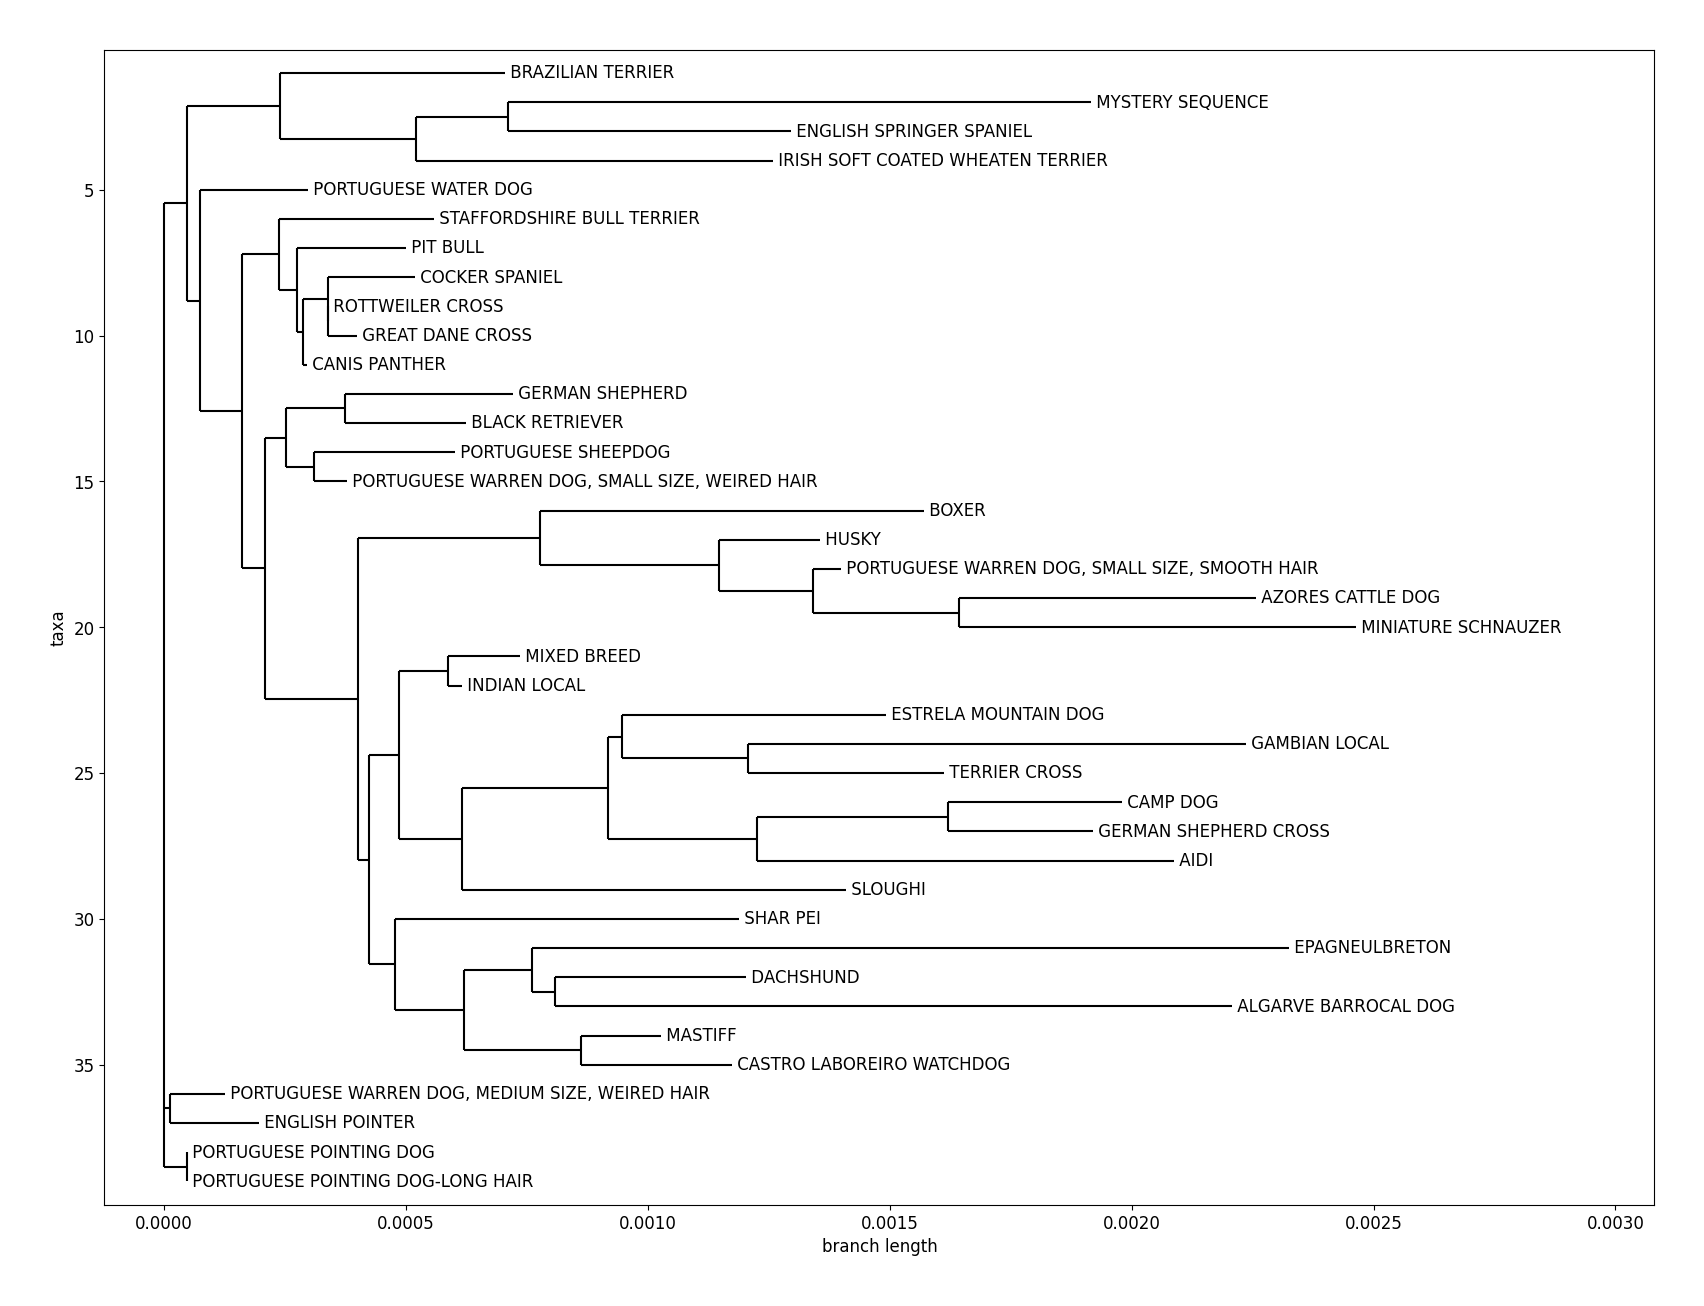

In [103]:
def MSA_alignment():
    """Create a multisequence alignment between unknownn dna and all consensus sequence"""
    #read the file with MSA alignment 
    sequences = SeqIO.parse(consensus_file, "fasta")
    # Create a MultipleSeqAlignment object
    MSA_alignment = Bio.Align.MultipleSeqAlignment(sequences)
    #create a directory and filename for the MSA alignment
    filename = f"{output}/MSA_alignment"  
    #save the multiple sequence alignment in a clustal file 
    AlignIO.write(MSA_alignment, filename, "clustal")
    return MSA_alignment

def build_phylo_tree(MSA_alignment = MSA_alignment()):
    """Create a distance matrix from the MSA alignment"""
    # Calculate the distance matrix
    calculator = DistanceCalculator("identity")
    #distance_matrix = calculator.get_distance(MSA_alignment)
    # Build the tree using the neighbor-joining method
    constructor = DistanceTreeConstructor(calculator, method="nj")
    breeds_tree = constructor.build_tree(MSA_alignment)
    # Save the tree to a new file 
    Phylo.write(build_phylo_tree(), "breeds_tree.xml", "phyloxml")
    return breeds_tree
    

#access the file where the nexus format tree is and save it in a variable 
breeds_xml = Phylo.read("breeds_tree.xml", "phyloxml")

# Create a custom label function that returns None for inner clade labels
def custom_label_func(node):
    """Creates better phylogenetic tree visualisation by removing unwanted labels and label characters"""
    if node.is_terminal():
        #remove the '' marks in names
        return (node.name).replace("'", "")
    #delete non terminal node labels 
    else:
        return None
    
#plot the tree 
fig = plt.figure(figsize=(20,15), dpi=100, frameon=True)
ax = plt.gca()
Phylo.draw(breeds_xml, show_confidence=True, axes=ax, label_func=custom_label_func)

fig.savefig(f"{output}/Phylogenetic_tree")


Probability 

In [116]:
#set the sequence length to mirror the real database
seq_len = 16729
#set the size of the database to mirror the real one 
database_size = 100

def base_content(sequence=mystery_sequence[0]):
    """generate the proportion of each base in a DNA sequence"""
    bases = ["G", "C", "T", "A"]
    bases_count = {}
    total_count = len(sequence)
    #itterate through each base of the sequence to find the percentage intiger of each base 
    for base in bases:
        bases_count[base] = int(sequence.count(base) / total_count * 100)
    return list(bases_count.values()) 

def random_DNA(length):
    """Generate random sequences with the same proportion of base content as the real sequence"""
    bases = ["G", "C", "T", "A"]
    #generate the DNA in form of a list of bases
    random_DNA = random.choices(bases, weights=base_content(), k=length)
    #output the sequence with bases joied together
    return (''.join(random_DNA) )

def random_sequences(database_size = database_size, seq_len = seq_len):
    """generates a list of sequences of the size and length of the original database"""
    rand_seq_database = []
    #reapeats the random DNA generation process to miror the database length
    for number in range(database_size):
        rand_seq = random_DNA(seq_len)
        #add each generated sequence to a list 
        rand_seq_database.append(rand_seq)
    return rand_seq_database
    
sequences = random_sequences()

#Calculate the alignment scores for each random alignment.
def alignment_scores(target = random_DNA(seq_len), sequences = sequences):
    """Generates alignment scores for all the sequences found in the random sequences list"""
    scores = []
    #itterates through the seequences in a list and generates an alignment score
    for sequence in sequences:
        alignment = simple_alignment(target, sequence)
        #alignment score is added to a list
        scores.append(alignment[0])
    #list of alignment scores is returned
    return scores

random_scores = alignment_scores()


{'PORTUGUESE WARREN DOG, SMALL SIZE, WEIRED HAIR ': [16703.0, 16729, 1], 'CASTRO LABOREIRO WATCHDOG ': [16686.0, 16728, 1], 'SLOUGHI ': [16684.0, 16709, 1], 'PORTUGUESE SHEEPDOG ': [16701.0, 16729, 1], 'AIDI ': [16670.0, 16703, 1], 'TERRIER CROSS ': [16677.0, 16704, 1], 'ENGLISH POINTER ': [16696.0, 16729, 1], 'CANIS PANTHER ': [16697.0, 16726, 1], 'ALGARVE BARROCAL DOG ': [16668.0, 16694, 1], 'PIT BULL ': [16693.0, 16726, 1], 'PORTUGUESE POINTING DOG-LONG HAIR ': [16698.0, 16729, 1], 'MINIATURE SCHNAUZER ': [16686.0, 16729, 1], 'BLACK RETRIEVER ': [16696.0, 16726, 1], 'IRISH SOFT COATED WHEATEN TERRIER ': [16698.0, 16728, 1], 'GERMAN SHEPHERD CROSS ': [16671.0, 16704, 1], 'DACHSHUND ': [16684.0, 16710, 1], 'STAFFORDSHIRE BULL TERRIER ': [16695.0, 16726, 1], 'CAMP DOG ': [16670.0, 16703, 1], 'PORTUGUESE WARREN DOG, MEDIUM SIZE, WEIRED HAIR ': [16699.0, 16729, 1], 'INDIAN LOCAL ': [16693.0, 16720, 1], 'BOXER ': [16695.0, 16735, 1], 'PORTUGUESE WATER DOG ': [16698.0, 16729, 1], 'PORTUGUE

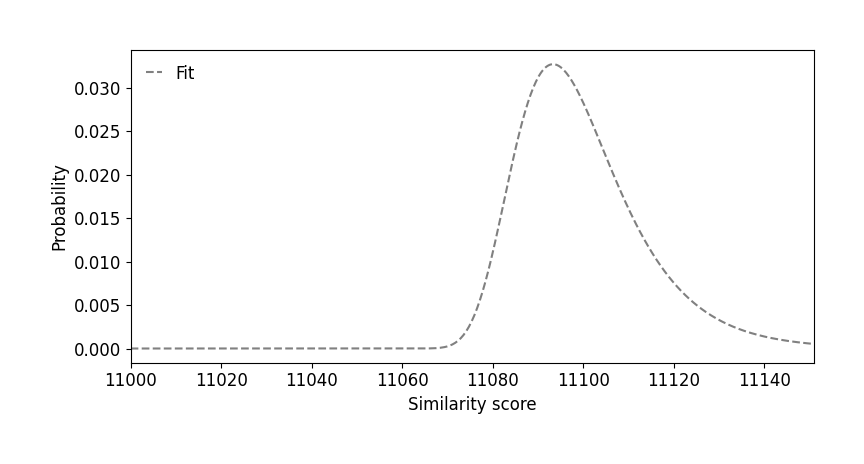

In [66]:
# Score frequencies of random sequence alignment scores
freqs = np.bincount(random_scores) / database_size

# Use method of moments to estimate distribution parameters
l = np.pi / np.sqrt(6 * np.var(random_scores))
u = np.mean(random_scores) - np.euler_gamma / l

# The probability density function of the extreme value distribution
def pdf(x, l, u):
    t = np.exp(-l * (x - u))
    return l * t * np.exp(-t)

# Coordinates for the fit
x = np.linspace(11000, len(freqs)-1, 500)
y = pdf(x, l, u)

#plot the probability graph 
fig, ax = plt.subplots(figsize=(8.0, 4.0))
ax.plot(x, y, color="gray", linestyle="--", label="Fit")
ax.set_xlabel("Similarity score")
ax.set_ylabel("Probability")
ax.set_xlim(11000, len(freqs)-1)
ax.legend(loc="upper left")
fig.tight_layout()
fig.savefig(f"{output}/probability_distribution")

In [64]:
#create a function to calculate alignment scores
def breed_alignment_scores(unknown_sequence = mystery_sequence[0]):
    """uses the simple alignment function to create an alignment between unknown sequence and consenus sequences. Returns a list of breeds with the corresponding alignment score."""
    #set up a list for all alignment score 
    scores = {}
    #itterate through the sequences in the database
    for instance in Breed_consensus.all_instances:
        #determine the score of each alignment
        score = (simple_alignment(instance.sequence, unknown_sequence)[0])
        #add score and sequence to scores dictionary
        scores[instance.breed] = [score, len(instance.sequence), len(unknown_sequence[0])]
    return scores

#save results of the function in a variable 
breed_scores = breed_alignment_scores()

In [67]:
#create a dataframe to strore the proability of the alignment with each breed consensus occuring by chance
def probability_df():
    probabilities = []
    #itterate through alignemnt scores of the actual dataset 
    for breed, score in zip(breed_scores.keys(), breed_scores.values()):
        #get the breed name and probability of alignment occuring by chance
        line = breed, pdf(score[0], l, u)
        #add the breed and probability to a list
        probabilities.append(line)
    #convert the list of breeds and probabilities to a dataframe
    df = pd.DataFrame(probabilities, columns=["breed", "probability"])
    #sor the dataframe so that the least likelly to occur by chance alignment is at the top 
    df = df.sort_values("probability")
    #save the dataframe to a file  
    df.to_csv(f'{output}/probability of alignment occuring by chance.csv')
    #funtion returns the dataframe create for testing and further modificaations purpouses
    return df